## Example of audio augmentation

This notebook demonstrates how to perform audio augmentation using the `Muda` and `librosa` library.

In this example, we will perform the following audio augmentations:

1. Pitch shifting
2. Time stretching
3. Dynamic range compression


In [1]:
from xai_music import Audiobank

audio_bank = Audiobank(config_file="configuration.yml")
audio_bank.synthesis(n_samples=1)

  0%|          | 0/8 [00:00<?, ?it/s]sox WARN compand: compand clipped 1 samples; decrease volume?
sox WARN dither: dither clipped 1 samples; decrease volume?
sox WARN compand: compand clipped 1 samples; decrease volume?
sox WARN compand: compand clipped 2 samples; decrease volume?
sox WARN dither: dither clipped 2 samples; decrease volume?
 38%|███▊      | 3/8 [00:31<00:51, 10.39s/it]sox WARN compand: compand clipped 1 samples; decrease volume?
sox WARN dither: dither clipped 1 samples; decrease volume?
sox WARN compand: compand clipped 1 samples; decrease volume?
sox WARN dither: dither clipped 1 samples; decrease volume?
sox WARN compand: compand clipped 1 samples; decrease volume?
sox WARN compand: compand clipped 1 samples; decrease volume?
sox WARN dither: dither clipped 1 samples; decrease volume?
sox WARN compand: compand clipped 2 samples; decrease volume?
sox WARN dither: dither clipped 2 samples; decrease volume?
sox WARN compand: compand clipped 2 samples; decrease volume?


## Plotting example of audio


In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

from IPython import display

In [3]:
def plot_audio(path: str) -> None:
    # Load the audio file
    y, sr = librosa.load(path, sr=16000)
    # Compute the spectrogram
    spectrogram = librosa.stft(y)
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

    # Plotting
    fig, axes = plt.subplots(2, figsize=(12, 8))

    # Waveform plot
    timescale = np.arange(y.shape[0])
    axes[0].plot(timescale, y)
    axes[0].set_title("Waveform")
    axes[0].set_xlim([0, y.shape[0]])

    # Spectrogram plot
    img = librosa.display.specshow(
        spectrogram_db, sr=sr, x_axis="time", y_axis="hz", ax=axes[1]
    )
    axes[1].set_title("Spectrogram")
    fig.colorbar(img, ax=axes[1], format="%+2.0f dB")

    # Title and show
    plt.suptitle(path.split("/")[-1].title())
    plt.show()

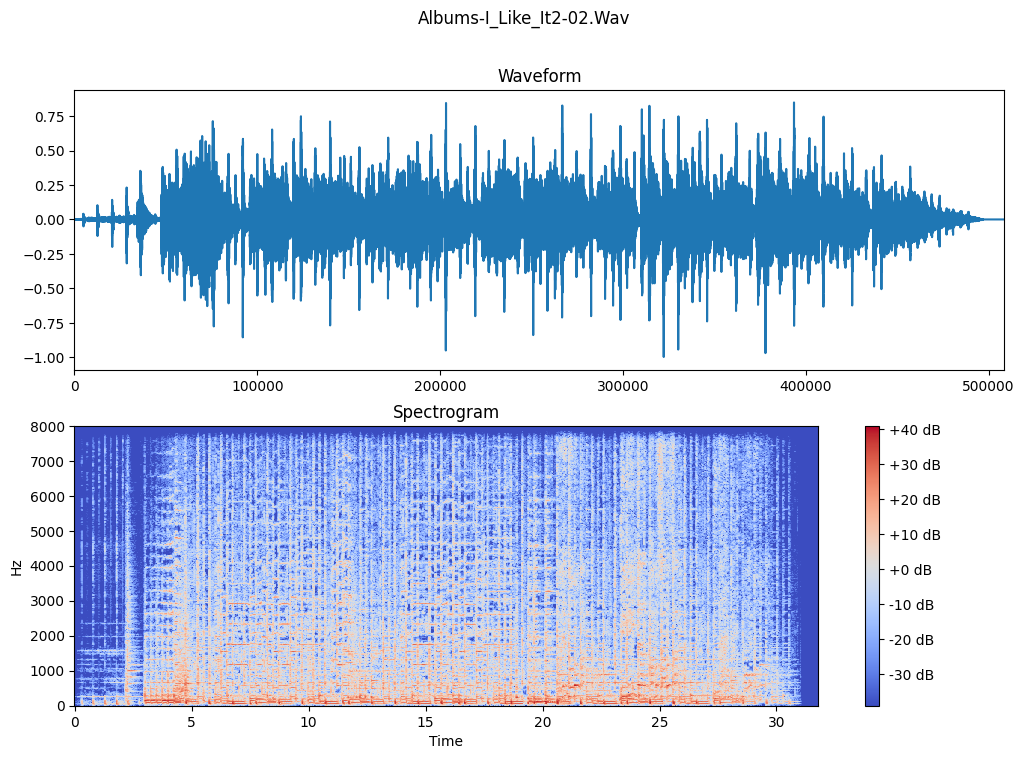

In [4]:
_MUSIC_PATH = r"wavfiles/ChaChaCha/Albums-I_Like_It2-02.wav"

plot_audio(_MUSIC_PATH)
display.display(display.Audio(_MUSIC_PATH, rate=16000))

In [5]:
import json


def extract_info_from_file(file_path: str) -> tuple:
    with open(file_path, "r") as file:
        data = json.load(file)
        # Initialize variables to store the extracted information
        n_semitones, rate, preset = None, None, None
        # Loop through the history of transformations to extract the required information
        for transformation in (
            data.get("sandbox", {}).get("muda", {}).get("history", [])
        ):
            transformer_class = transformation.get("transformer", {}).get(
                "__class__", ""
            )
            if transformer_class == "LinearPitchShift":
                n_semitones = transformation.get("state", {}).get("n_semitones")
            elif transformer_class == "LogspaceTimeStretch":
                rate = transformation.get("state", {}).get("rate")
            elif transformer_class == "DynamicRangeCompression":
                preset = transformation.get("state", {}).get("preset")
        return n_semitones, rate, preset

Pitch Shift (Semitones): -2.0
Time Stretch Rate: 0.5
Dynamic Range Compression Preset: radio


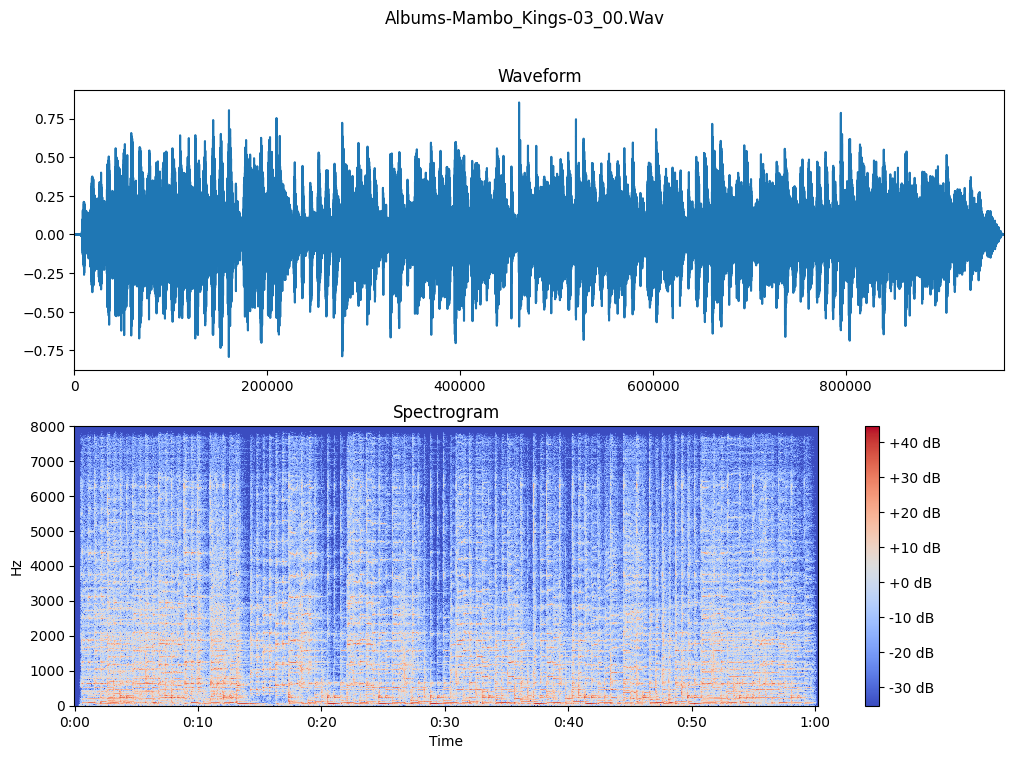

In [7]:
_MUSIC_PATH = r"audio/augments/wav/ChaChaCha/Albums-Mambo_Kings-03_00.wav"
_JAM_PATH = r"audio/augments/meta/ChaChaCha/Albums-Mambo_Kings-03_00.jams"
# Extract augmentation features from the jams file
n_semitones, rate, preset = extract_info_from_file(_JAM_PATH)
print(f"Pitch Shift (Semitones): {n_semitones}")
print(f"Time Stretch Rate: {rate}")
print(f"Dynamic Range Compression Preset: {preset}")

plot_audio(_MUSIC_PATH)
display.display(display.Audio(_MUSIC_PATH, rate=16000))

## Extract augmentation features from jams file


In [8]:
import pandas as pd
import json
import os
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()


def extract_info_from_file(file_path: str) -> tuple:
    with open(file_path, "r") as file:
        data = json.load(file)
        # Initialize variables to store the extracted information
        n_semitones, rate, preset = None, None, None
        # Loop through the history of transformations to extract the required information
        for transformation in (
            data.get("sandbox", {}).get("muda", {}).get("history", [])
        ):
            transformer_class = transformation.get("transformer", {}).get(
                "__class__", ""
            )
            if transformer_class == "LinearPitchShift":
                n_semitones = transformation.get("state", {}).get("n_semitones")
            elif transformer_class == "LogspaceTimeStretch":
                rate = transformation.get("state", {}).get("rate")
            elif transformer_class == "DynamicRangeCompression":
                preset = transformation.get("state", {}).get("preset")
        return n_semitones, rate, preset


def create_dataframe_from_dir(directory_path: str) -> pd.DataFrame:
    # Define the DataFrame columns
    df = pd.DataFrame(
        columns=["file_name", "type", "n_semitones", "rate", "preset", "y_id", "y"]
    )
    # Iterate over each file in the directory
    file_list = [
        os.path.join(root, file)
        for root, _, files in os.walk(directory_path)
        for file in files
        if file.endswith(".jams")
    ]
    for file_name in file_list:
        n_semitones, rate, preset = extract_info_from_file(file_name)
        # Extract type of music from the file path or name
        type_of_music = file_name.split("/")[-2]
        # Get the file name without extension
        base_file_name = os.path.splitext(os.path.basename(file_name))[0]
        # Append the extracted information to the DataFrame
        new_row = pd.DataFrame(
            {
                "n_semitones": [n_semitones],
                "rate": [rate],
                "preset": [preset],
                "type": [type_of_music],
                "file_name": [base_file_name],
            }
        )
        df = pd.concat([df, new_row], ignore_index=True)
    # Convert preset to index
    df["preset"] = le.fit_transform(df["preset"])
    return df

In [9]:
int_df = create_dataframe_from_dir(r"audio/augments/meta")
model_features = ["file_name", "n_semitones", "rate", "preset"]
int_df

/var/folders/pz/4plff07x5_b3hdby9tw8psvm0000gn/T/ipykernel_9270/2408985852.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


file_name       type  n_semitones      rate  preset y_id  \
0      Albums-Latin_Jam4-08_93      Rumba         -2.0  1.414214       3  NaN   
1      Albums-Latin_Jam4-08_85      Rumba          2.0  1.000000       1  NaN   
2     Albums-Latin_Jam4-08_119      Rumba          2.0  1.414214       5  NaN   
3      Albums-Latin_Jam4-08_46      Rumba          0.0  0.707107       2  NaN   
4      Albums-Latin_Jam4-08_11      Rumba         -1.0  0.500000       5  NaN   
...                        ...        ...          ...       ...     ...  ...   
1195          Media-105207_123  Quickstep         -2.0  2.000000       3  NaN   
1196           Media-105207_17  Quickstep          0.0  0.500000       5  NaN   
1197          Media-105207_135  Quickstep          0.0  2.000000       3  NaN   
1198           Media-105207_01  Quickstep         -2.0  0.500000       1  NaN   
1199           Media-105207_56  Quickstep          2.0  0.707107       0  NaN   

        y  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
...   ...  
1195  NaN  
1196  NaN  
1197  NaN  
1198  NaN  
1199  NaN  

[1200 rows x 7 columns]

### Loading music classification model trained on ballroom dataset

In [11]:
import tensorflow as tf

model = tf.saved_model.load(r"./saved")

model(r"audio/augments/wav/ChaChaCha/Albums-Mambo_Kings-03_00.wav")

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[0.08405121, 0.01064704, 0.04074297, 0.05019915, 0.07481423,
         0.697591  , 0.01223917, 0.02971522]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Tango'], dtype=object)>}

### Predict each augmented music file

In [12]:
import os
from tqdm import tqdm

for i, row in tqdm(int_df.iterrows(), total=int_df.shape[0]):
    # Join the path with the file name for each row in the DataFrame
    audio_file = os.path.join(
        r"audio/augments/wav", row["type"], row["file_name"] + ".wav"
    )
    prediction = model(audio_file)
    int_df.at[i, "y"] = prediction["class_names"].numpy()[0].decode("utf-8")
    int_df.at[i, "y_id"] = prediction["class_ids"].numpy()[0]

100%|██████████| 1200/1200 [37:08<00:00,  1.86s/it]


In [23]:
int_df.to_csv("augmentation_results.csv", index=False)

int_df

file_name       type  n_semitones      rate  preset y_id  \
0      Albums-Latin_Jam4-08_93      Rumba         -2.0  1.414214       3    5   
1      Albums-Latin_Jam4-08_85      Rumba          2.0  1.000000       1    5   
2     Albums-Latin_Jam4-08_119      Rumba          2.0  1.414214       5    5   
3      Albums-Latin_Jam4-08_46      Rumba          0.0  0.707107       2    7   
4      Albums-Latin_Jam4-08_11      Rumba         -1.0  0.500000       5    7   
...                        ...        ...          ...       ...     ...  ...   
1195          Media-105207_123  Quickstep         -2.0  2.000000       3    7   
1196           Media-105207_17  Quickstep          0.0  0.500000       5    7   
1197          Media-105207_135  Quickstep          0.0  2.000000       3    7   
1198           Media-105207_01  Quickstep         -2.0  0.500000       1    7   
1199           Media-105207_56  Quickstep          2.0  0.707107       0    7   

          y  
0     Tango  
1     Tango  
2     Tango  
3     Waltz  
4     Waltz  
...     ...  
1195  Waltz  
1196  Waltz  
1197  Waltz  
1198  Waltz  
1199  Waltz  

[1200 rows x 7 columns]

### Encode type

In [24]:
styles = {
    "Tango": 5,
    "Waltz": 7,
    "Rumba": 3,
    "Quickstep": 2,
    "Samba": 4,
    "Jive": 1,
    "ChaChaCha": 0,
    "VienneseWaltz": 6,
}

# Encode the 'type' column in int_df based on the styles dictionary
int_df["type_encoded"] = int_df["type"].map(styles)

int_df

file_name       type  n_semitones      rate  preset y_id  \
0      Albums-Latin_Jam4-08_93      Rumba         -2.0  1.414214       3    5   
1      Albums-Latin_Jam4-08_85      Rumba          2.0  1.000000       1    5   
2     Albums-Latin_Jam4-08_119      Rumba          2.0  1.414214       5    5   
3      Albums-Latin_Jam4-08_46      Rumba          0.0  0.707107       2    7   
4      Albums-Latin_Jam4-08_11      Rumba         -1.0  0.500000       5    7   
...                        ...        ...          ...       ...     ...  ...   
1195          Media-105207_123  Quickstep         -2.0  2.000000       3    7   
1196           Media-105207_17  Quickstep          0.0  0.500000       5    7   
1197          Media-105207_135  Quickstep          0.0  2.000000       3    7   
1198           Media-105207_01  Quickstep         -2.0  0.500000       1    7   
1199           Media-105207_56  Quickstep          2.0  0.707107       0    7   

          y  type_encoded  
0     Tango             3  
1     Tango             3  
2     Tango             3  
3     Waltz             3  
4     Waltz             3  
...     ...           ...  
1195  Waltz             2  
1196  Waltz             2  
1197  Waltz             2  
1198  Waltz             2  
1199  Waltz             2  

[1200 rows x 8 columns]

### LIME NotImplementation

In [29]:
import numpy as np
from sklearn.linear_model import Lasso


def lime_explanation(local_data, predictions, instance, num_features, alpha=0.1):
    # Ensure local_data and instance are numpy arrays of type float
    if isinstance(local_data, pd.DataFrame):
        local_data = local_data.values.astype(float)
    if isinstance(instance, pd.Series):
        instance = instance.values.astype(float)

    # Step 1: Compute distances (weights) based on proximity to the instance
    distances = np.sqrt(np.sum((local_data - instance) ** 2, axis=1))
    weights = np.exp(-distances)

    # Step 2: Train a weighted, interpretable model (Lasso)
    explanation_model = Lasso(alpha=alpha, max_iter=10000, fit_intercept=True)
    explanation_model.fit(local_data, predictions, sample_weight=weights)

    # Step 3: Reduce the number of features to num_features using feature selection
    # Here, we use Lasso's inherent feature selection
    # Retrain if necessary to adjust the number of features
    while np.count_nonzero(explanation_model.coef_) > num_features:
        alpha += 0.01  # Increase regularization
        explanation_model = Lasso(alpha=alpha, max_iter=10000, fit_intercept=True)
        explanation_model.fit(local_data, predictions, sample_weight=weights)

    return explanation_model.coef_

### Compute all augmented files

In [42]:
features = ["n_semitones", "rate", "preset", "type_encoded"]


coef = lime_explanation(int_df[features], int_df["y_id"], int_df.iloc[0][features], 4)
pd.DataFrame([coef], columns=features)


n_semitones      rate  preset  type_encoded
0    -0.080115 -1.025943    -0.0      0.041639

### Separate table by class type

In [36]:
separated_dfs = {
    type_code: group for type_code, group in int_df.groupby("type_encoded")
}

### Compute coefficients for each class type

In [43]:
coef_by_type_code = {}
for k, v in separated_dfs.items():
    coef_by_type_code[k] = lime_explanation(
        v[features], v["y_id"], v.iloc[0][features], 4
    )
    
coef_by_type_code

{0: array([-0.50553189, -0.        , -0.        ,  0.        ]),
 1: array([ 0.19685789, -0.05858595, -0.        ,  0.        ]),
 2: array([-0.05003493, -1.43962134, -0.11254955,  0.        ]),
 3: array([-0.38605871, -1.78810303,  0.        ,  0.        ]),
 4: array([-0.      , -1.658178,  0.      ,  0.      ]),
 5: array([-0., -0., -0.,  0.]),
 6: array([ 0.27541514, -0.        ,  0.        ,  0.        ]),
 7: array([-0.        ,  1.76178662,  0.04692097,  0.        ])}

In [41]:
import pandas as pd

# Convert the dictionary of coefficients into a DataFrame
coef_df = pd.DataFrame.from_dict(coef_by_type_code, orient='index', columns=features)
coef_df.index.name = 'type_id'
coef_df.reset_index(inplace=True)
# Reverse the styles dictionary to map from type_id to type
id_to_type = {v: k for k, v in styles.items()}

# Add 'type' column to coef_df
coef_df['type'] = coef_df['type_id'].map(id_to_type)

# Display the updated DataFrame
coef_df


type_id  n_semitones      rate    preset  type_encoded           type
0        0    -0.505532 -0.000000 -0.000000           0.0      ChaChaCha
1        1     0.196858 -0.058586 -0.000000           0.0           Jive
2        2    -0.050035 -1.439621 -0.112550           0.0      Quickstep
3        3    -0.386059 -1.788103  0.000000           0.0          Rumba
4        4    -0.000000 -1.658178  0.000000           0.0          Samba
5        5    -0.000000 -0.000000 -0.000000           0.0          Tango
6        6     0.275415 -0.000000  0.000000           0.0  VienneseWaltz
7        7    -0.000000  1.761787  0.046921           0.0          Waltz